In [11]:
import torch

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# Data

In [13]:
import os
import pickle
raw_file = './../data/dump/mimic.pickle'
with open(raw_file, 'rb') as handle:
    data = pickle.load(handle)

In [14]:
print(type(data))
print(type(data[0]))
print(data[0].keys())

<class 'list'>
<class 'dict'>
dict_keys([0, 1, 2])


In [15]:
import matplotlib.pyplot as plt

(array([1.473e+03, 7.100e+01, 2.600e+01, 5.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

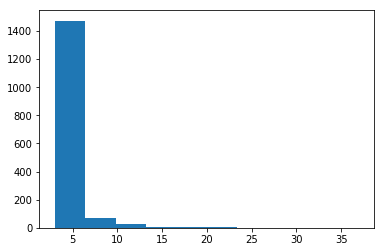

In [16]:
plt.hist(list(map(len, data)))

In [17]:
# [i for i in data[0].values()]

## Convert to dataframe

In [18]:
import pandas
import numpy as np

In [19]:
def gender_to_categorical(x):
    return 0 if x=='M' else 1

def mimic_correct_datatypes(icu_df):

    # TIMES
    icu_df['ADMITTIME'] = icu_df['ADMITTIME'].astype('datetime64')
    icu_df['DEATHTIME'] = icu_df['DEATHTIME'].astype('datetime64')
    icu_df['DISCHTIME'] = icu_df['DISCHTIME'].astype('datetime64')
    icu_df['INTIME'] = icu_df['INTIME'].astype('datetime64')
    icu_df['OUTTIME'] = icu_df['OUTTIME'].astype('datetime64')
    icu_df['DOB'] = icu_df['DOB'].astype('datetime64')

    # FLOATS
    icu_df['AGE'] = icu_df['AGE'].astype('float32')
    icu_df['LOS'] = icu_df['LOS'].astype('float32')

    # INTS
    icu_df['SUBJECT_ID'] = icu_df['SUBJECT_ID'].astype('int')
    icu_df['HADM_ID'] = icu_df['HADM_ID'].astype('int')
    icu_df['ICUSTAY_ID'] = icu_df['ICUSTAY_ID'].astype('int')
    icu_df['MORTALITY'] = icu_df['MORTALITY'].astype('int')
    return icu_df

In [63]:
def mimic_data_to_df(data, colnames=None):
    flat_data = [icu_visit for data_i in data for icu_visit in data_i.values()]
    icu_df = pandas.DataFrame(flat_data)
    icu_df = mimic_correct_datatypes(icu_df)
    # Make gender a 0/1 variable
    icu_df['GENDER'] = icu_df['GENDER'].apply(gender_to_categorical)
    
    # Make ETHNICITY a one-hot feature set, removing the first column to ensure there is no linear dependence
    ethnicity_dummies = pandas.get_dummies(icu_df.ETHNICITY, drop_first=True, prefix='ETHNICITY_')
    icu_df = pandas.concat([icu_df.drop('ETHNICITY', axis=1), ethnicity_dummies], axis=1)
    
    # Center the AGE column
    icu_df['AGE'] = (icu_df.AGE - icu_df.AGE.mean()) / icu_df.AGE.std()
    
    if colnames is None:
        return icu_df
    else:
        return icu_df[colnames]

## Datatypes

In [75]:
from utils.synthetic_data import get_intervals
def compute_admit_times(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            admit_times: Tensor of shape T x N x 2
    """
    max_visit_n = max([len(data_i) for data_i in data])
    admit_times = []
    for data_i in data:
        patient_admit_times = [icu_visit['ADMITTIME'] for icu_visit in data_i.values()]
        # Convert the date times str -> datetime64 -> int
        patient_admit_times = np.array(patient_admit_times).astype(np.datetime64).astype('int')
        patient_visit_n = len(patient_admit_times)
        patient_admit_times = np.pad(patient_admit_times, (0,max_visit_n-patient_visit_n), mode='constant')
        admit_times.append(patient_admit_times)
    admit_times = np.stack(admit_times).T
    admit_times = (admit_times - admit_times.min()) / (admit_times.max() - admit_times.min())
    admit_times = torch.tensor(admit_times).float().to(device)
    intervals = get_intervals(admit_times)
    admit_times = torch.stack([admit_times, intervals], dim=-1)
    return admit_times

In [42]:
def compute_markers(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            admit_times: Tensor of shape T x N x marker_dim
    """
    max_visit_n = max([len(data_i) for data_i in data])
    markers = []
    icu_df = mimic_data_to_df(data)
    icu_df = icu_df.filter(regex='AGE|GENDER|^ETHNICITY|SUBJECT_ID', axis=1)
    group_patients = icu_df.groupby('SUBJECT_ID', )
    for patient_idx, patient_df_rows in group_patients.groups.items():
        # Get an array of shape  (T_i x marker_dim)
        patient_markers = icu_df.iloc[patient_df_rows].drop('SUBJECT_ID', axis=1).values
        t_i, marker_dim = patient_markers.shape
        # Get an array of shape  (T_max x marker_dim)
        patient_markers = np.pad(patient_markers, pad_width=((0,max_visit_n - t_i), (0,0)), mode='constant')
        markers.append(patient_markers)
    # Shape = T x N x marker_dim
    markers = np.stack(markers).transpose((1,0,2))
    markers = torch.tensor(markers)
    return markers

In [39]:
def mimic_data_tensors(data):
    admit_times = compute_admit_times(data)
    markers = compute_markers(data)
    data_dict = {
        't': admit_times,
        'x': markers
    }
    return data_dict

In [24]:
mimic_data = mimic_data_tensors(data)

In [27]:
mimic_data['x'].max()

tensor(99982., dtype=torch.float64)

In [64]:
icu_df = mimic_data_to_df(data)

In [76]:
marker_tensor = compute_markers(data)
time_tensor = compute_admit_times(data)

In [72]:
marker_tensor.shape, time_tensor.shape

(torch.Size([37, 1585, 31]), torch.Size([37, 1585, 2]))

In [77]:
time_tensor

tensor([[[6.7869e-01, 6.7869e-01],
         [9.0349e-01, 9.0349e-01],
         [7.5369e-01, 7.5369e-01],
         ...,
         [6.6664e-01, 6.6664e-01],
         [5.9738e-01, 5.9738e-01],
         [8.1326e-01, 8.1326e-01]],

        [[6.9876e-01, 2.0068e-02],
         [9.0648e-01, 2.9978e-03],
         [7.5672e-01, 3.0349e-03],
         ...,
         [6.7251e-01, 5.8703e-03],
         [5.9744e-01, 5.4121e-05],
         [8.2355e-01, 1.0281e-02]],

        [[7.1304e-01, 1.4287e-02],
         [9.1713e-01, 1.0643e-02],
         [7.5736e-01, 6.3676e-04],
         ...,
         [6.7273e-01, 2.1601e-04],
         [5.9770e-01, 2.6083e-04],
         [8.3123e-01, 7.6807e-03]],

        ...,

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00],
         [0.